# Figure 2b. Scalings for direct contacts, +1 and indirect contacts

In this notebook we'll assume that Mitter et al. 2020 scsHi-C dataset was already mapped with distiller-nf and located in `./data/` folder. 
We will take all the data for the `Hi-C_4h` experiment.

We'll need to parse it in "expand" mode (combinatorial expansion of all possible contacts).
We will also report the type of interactions and, thus, can separate direct and indirect contacts below:

In [8]:
### Prepare the genome:
import bioframe

hg38_chromsizes = bioframe.fetch_chromsizes('hg38', as_bed=True)
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens, cols_chroms=hg38_chromsizes.columns)

hg38_chromsizes[['chrom', 'end']].to_csv('./data/hg38.reduced.chrom.sizes', sep='\t', header=False, index=False)
hg38_arms.to_csv("./data/hg38.arms.viewframe.tsv", sep='\t', header=True, index=False)

In [ ]:
%%bash

pairtools parse2 --expand -c data/hg38.reduced.chrom.sizes \
  --drop-seq --drop-sam --add-pair-index \
  --no-flip --report-orientation pair data/bams/Hi-C_4h.lane1.hg38.01.bam \
  -o data/pairs/Hi-C_4h.lane1.hg38.01.pairs

for pref in Hi-C_4h.lane1.hg38.01 Hi-C_4h.lane1.hg38.02 Hi-C_4h.lane1.hg38.03 Hi-C_4h.lane2.hg38.01 Hi-C_4h.lane2.hg38.02 Hi-C_4h.lane2.hg38.03
do 
    pairtools parse2 --expand -c data/hg38.reduced.chrom.sizes \
      --drop-seq --drop-sam --add-pair-index \
      --no-flip --report-orientation pair --report-position outer \
      data/bams/${pref}.bam \
      -o data/pairs/${pref}.pairs
done

## Separately report direct and indirect contacts

In [3]:
%%bash 
# Select only indirect intercations:
pairtools select "(walk_pair_type=='R1-2')" data/pairs/Hi-C_4h.lane1.hg38.01.pairs -o data/pairs/Hi-C_4h.lane1.hg38.01.indirect.pairs

# Select only direct intercations:
pairtools select "(walk_pair_type=='R1') or (walk_pair_type=='R2') or (walk_pair_type=='R1&2')" data/pairs/Hi-C_4h.lane1.hg38.01.pairs -o data/pairs/Hi-C_4h.lane1.hg38.01.direct.pairs

# Select only intercations with one intermingling neighbor:
pairtools select "(walk_pair_type=='E1_R1') or (walk_pair_type=='E1_R2') or (walk_pair_type=='E1_R1&2')" data/pairs/Hi-C_4h.lane1.hg38.01.pairs -o data/pairs/Hi-C_4h.lane1.hg38.01.E1.pairs


In [ ]:
for pref in Hi-C_4h.lane1.hg38.01 Hi-C_4h.lane1.hg38.02 Hi-C_4h.lane1.hg38.03 Hi-C_4h.lane2.hg38.01 Hi-C_4h.lane2.hg38.02 Hi-C_4h.lane2.hg38.03
do

    # Select only indirect intercations:
    pairtools select "(walk_pair_type=='R1-2')" data/pairs/${pref}.pairs -o data/pairs/${pref}.indirect.pairs

    # Select only direct intercations:
    pairtools select "(walk_pair_type=='R1') or (walk_pair_type=='R2') or (walk_pair_type=='R1&2')" data/pairs/${pref}.pairs -o data/pairs/Hi-C_4h.lane1.hg38.01.direct.pairs

    # Select only intercations across one fragment:
    pairtools select "(walk_pair_type=='E1_R1') or (walk_pair_type=='E1_R2') or (walk_pair_type=='E1_R1&2')" data/pairs/${pref}.pairs -o data/pairs/${pref}.E1.pairs

    # Select only intercations across 2 fragments:
    pairtools select "(walk_pair_type=='E2_R1') or (walk_pair_type=='E2_R2') or (walk_pair_type=='E2_R1&2')" data/pairs/${pref}.pairs -o data/pairs/${pref}.E2.pairs

    # Select only intercations across 3 fragments:
    pairtools select "(walk_pair_type=='E3_R1') or (walk_pair_type=='E3_R2') or (walk_pair_type=='E3_R1&2')" data/pairs/${pref}.pairs -o data/pairs/${pref}.E3.pairs

done

In [ ]:
%%bash
# Merge all the files together: 
for pair_type in E2 E3 E4 E5 E6 E7 E8 E9  #indirect direct E1 
do
    pairtools merge --no-concatenate --keep-first-header ./data/pairs/*.${pair_type}.pairs -o ./data/pairs/Hi-C_4h.all-${pair_type}.pairs
done

In [ ]:
%%bash 
# Calculate stats:
for pair_type in E2 E3 E4 E5 E6 E7 E8 E9 # indirect direct E1 
do
    echo $pair_type
    pairtools stats ./data/pairs/Hi-C_4h.all-${pair_type}.pairs -o ./data/pairs/Hi-C_4h.all-${pair_type}.stats
done

In [ ]:
%%bash 
# Calculate scalings:
for pair_type in E2 E3 E4 E5 E6 E7 E8 E9 # indirect direct E1 
do
    echo $pair_type
    pairtools scaling --view ./data/hg38.arms.viewframe.tsv ./data/pairs/Hi-C_4h.all-${pair_type}.pairs -o ./data/pairs/Hi-C_4h.all-${pair_type}.scaling
done

## Visualize results

In [1]:
## Debug development mode
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker 
import matplotlib.gridspec 
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-whitegrid')

import bioframe

import pairtools
from pairtools.lib import scaling

In [94]:
def plot(cis_scalings, trans_levels, 
         n_total=None, xlim=(1e1,1e7), 
         label='', orientations=['+-', '-+', '++', '--'], 
         norm=False, ax=None, colors=None # length is [orientations + trans]
        ):
    
    if ax is None: 
        fig, ax = plt.subplots(1,1)
        
    if colors is None: 
        cmap = plt.get_cmap('tab10', len(orientations))
        colors = [cmap(i) for i in np.linspace(0, 1, len(orientations))] + ['black']
        
    strand_gb = cis_scalings.groupby(['strand1', 'strand2'])
    for i, strands in enumerate(orientations):
        if strands=="all":
            sc_strand = cis_scalings
        else:
            sc_strand = strand_gb.get_group(tuple(strands))
        sc_agg = (sc_strand
            .groupby(['min_dist','max_dist'])
            .agg({'n_pairs':'sum', 'n_bp2':'sum'})
            .reset_index())

        dist_bin_mids = np.sqrt(sc_agg.min_dist * sc_agg.max_dist)
        pair_frequencies = sc_agg.n_pairs / sc_agg.n_bp2
        if n_total is not None:
            pair_frequencies = pair_frequencies/n_total #cis_scalings.n_pairs.sum()
        mask = pair_frequencies>0
        label_long = f'{strands[0]}{strands[1]} {label}'

        if norm:
            pair_frequencies = scaling.unity_norm_scaling(
                np.concatenate([dist_bin_mids, [np.nan]]), 
                pair_frequencies, 
                norm_range=[1e4, 1e7]
            )
        if np.sum(mask)>0:
            ax.loglog(
                dist_bin_mids[mask],
                pair_frequencies[mask],
                label=label_long,
                lw=2,
                color=colors[i]
            )

    ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0,numticks=20))
    ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0,numticks=20))
    ax.set_aspect(1.0)
    ax.set_xlim(xlim)

    if not colors[-1] is None: 
        avg_trans = (
            trans_levels.n_pairs.astype('float64').sum() 
            / trans_levels.np_bp2.astype('float64').sum()
        )
        if n_total is not None:
            avg_trans = avg_trans/n_total

        ax.axhline(avg_trans, ls='--', c=colors[-1], label='avg trans {label}')

    ax.grid(lw=0.5,color='gray')
    ax.legend(loc="upper right")
    ax.set_ylabel('contact frequency, \nHi-C molecule per bp pair normalized by total')
    ax.set_xlabel('distance, bp')


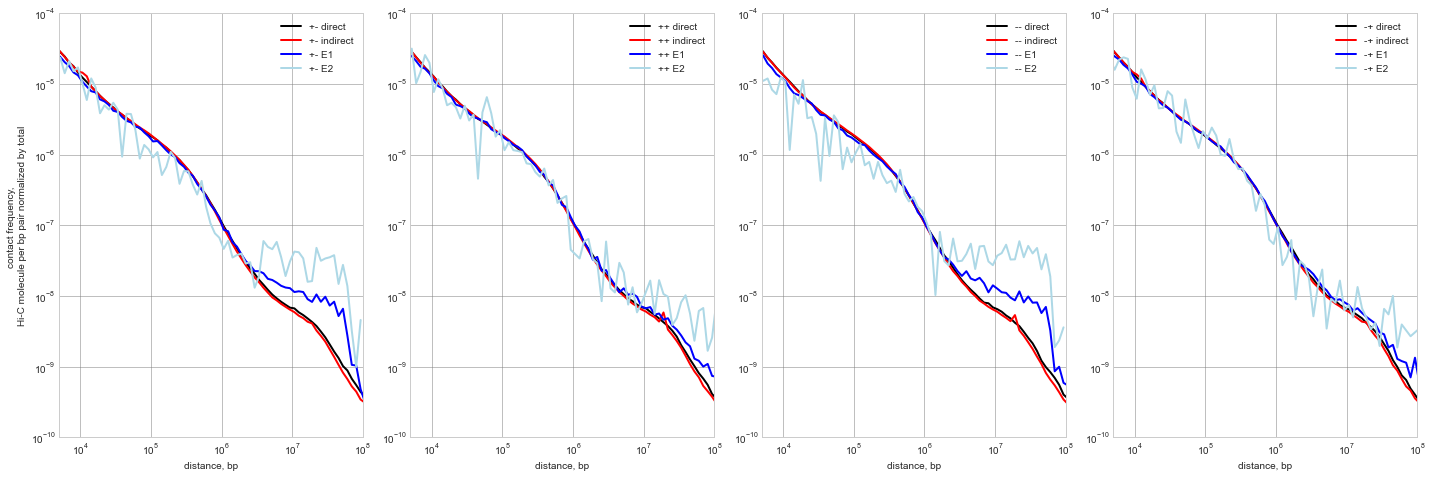

In [95]:
fig, axes = plt.subplots(1, 4, figsize=[20,10])

colors = ['black', 'red', 'blue', 'lightblue']
pair_types = ["direct", "indirect", "E1", "E2"]

for i, orientation in enumerate( ["+-", "++", "--", "-+"] ):
    for color, pair_type in zip(colors, pair_types):
        df_scaling = pd.read_table(f'./data/pairs/Hi-C_4h.all-{pair_type}.scaling')
        plot(cis_scalings=df_scaling.query('chrom1==chrom2'), trans_levels=df_scaling.query('chrom1!=chrom2'), 
             n_total=None, xlim=(5e3,1e8), orientations=[orientation], norm=True, ax=axes[i], label=pair_type, colors=[color, None])

    axes[i].set_ylim(1e-10, 1e-4)
    if i!=0:
        axes[i].set_ylabel("")
    
fig.tight_layout()

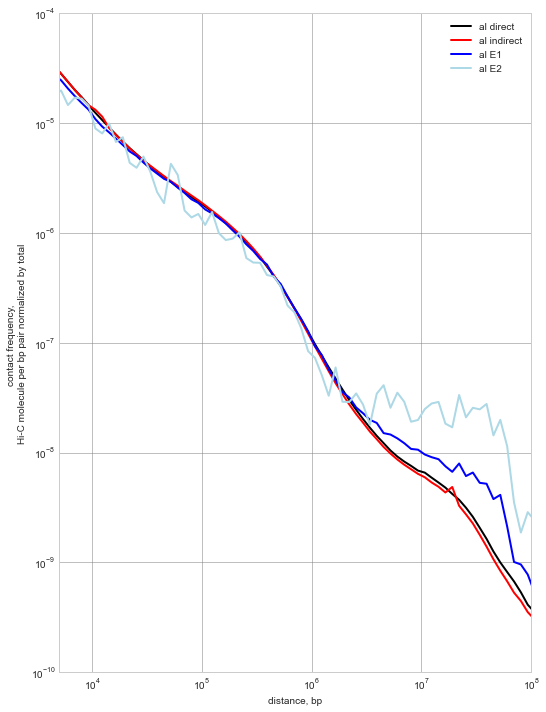

In [101]:
fig, axes = plt.subplots(1, 1, figsize=[20,10])

colors = ['black', 'red', 'blue', 'lightblue']
pair_types = ["direct", "indirect", "E1", "E2"]

for i, orientation in enumerate( ["all"] ):
    for color, pair_type in zip(colors, pair_types):
        df_scaling = pd.read_table(f'./data/pairs/Hi-C_4h.all-{pair_type}.scaling')
        plot(cis_scalings=df_scaling.query('chrom1==chrom2'), trans_levels=df_scaling.query('chrom1!=chrom2'), 
             n_total=None, xlim=(5e3,1e8), orientations=[orientation], norm=True, ax=axes, label=pair_type, colors=[color, None])

    axes.set_ylim(1e-10, 1e-4)
    
fig.tight_layout()

fig.savefig("./Figure2b.pdf")